Quickstart Colab for the **NeurIPS 2021 (Outstanding Paper Award)**: [Deep RL at the Edge of the Statistical Precipice](https://agarwl.github.io/rliable).

See [github.com/google-research/rliable](https://github.com/google-research/rliable) for more details.

Copyright 2021 Authors. SPDX-License-Identifier: Apache-2.0

In [3]:
#@title LICENSE
 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
# !pip3 install git+https://github.com/google-research/rliable
# !pip3 install inflection

In [4]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

In [5]:
# @title Imports
 
import collections
import numpy as np
import matplotlib.patches as patches
import sys
import pickle
import pandas as pd
import copy
import functools
import json
import os

import itertools as it
import random
import inspect
import scipy.stats
 
import getpass
import os.path as osp
 
# See warnings only once
import warnings
warnings.filterwarnings('default')
 
import inflection
from functools import partial

# The answer to life, universe and everything
RAND_STATE = np.random.RandomState(42)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [6]:
#@title Plotting: Seaborn style and matplotlib params
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("white")

# Matplotlib params
from matplotlib import rcParams
from matplotlib import rc

rcParams['legend.loc'] = 'best'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rc('text', usetex=False)

In [7]:
#@title Plotting Helpers

def save_fig(fig, name):
  file_name = '{}.pdf'.format(name)
  fig.savefig(file_name, format='pdf', bbox_inches='tight')
  # files.download(file_name) 
  return file_name

def set_axes(ax, xlim, ylim, xlabel, ylabel):
  ax.set_xlim(xlim)
  ax.set_ylim(ylim)
  ax.set_xlabel(xlabel, labelpad=14)
  ax.set_ylabel(ylabel, labelpad=14)
 
def set_ticks(ax, xticks, xticklabels, yticks, yticklabels):
  ax.set_xticks(xticks)
  ax.set_xticklabels(xticklabels)
  ax.set_yticks(yticks)
  ax.set_yticklabels(yticklabels)

def decorate_axis(ax, wrect=10, hrect=10, labelsize='large'):
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=labelsize)
  # Pablos' comment
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))

In [8]:
#@title Authenticate user to access GCP bucket (copy and enter the authentication code when you run the cell)
# from google.colab import auth
# auth.authenticate_user()

In [9]:
#@title Helpers for normalizing scores and plotting histogram plots.


def pgs(f):
  print(inspect.getsource(f))

def score_normalization(res_dict, min_scores, max_scores):
  games = res_dict.keys()
  norm_scores = {}
  for game, scores in res_dict.items():
    norm_scores[game] = (scores - min_scores[game])/(max_scores[game] - min_scores[game])
  return norm_scores


def convert_to_matrix(score_dict):
   keys = sorted(list(score_dict.keys()))
   return np.stack([score_dict[k] for k in keys], axis=1)

def plot_score_hist(score_matrix, bins=20, figsize=(28, 14), 
                    fontsize='xx-large', N=6, extra_row=1,
                    names=None):
  num_tasks = score_matrix.shape[1]
  if names is None:
    names = ATARI_100K_GAMES
  N1 = (num_tasks // N) + extra_row
  fig, ax = plt.subplots(nrows=N1, ncols=N, figsize=figsize)
  for i in range(N):
    for j in range(N1):
      idx = j * N + i
      if idx < num_tasks:
        ax[j, i].set_title(names[idx], fontsize=fontsize)
        sns.histplot(score_matrix[:, idx], bins=bins, ax=ax[j,i], kde=True)
      else:
        ax[j, i].axis('off')
      decorate_axis(ax[j, i], wrect=5, hrect=5, labelsize='xx-large')
      ax[j, i].xaxis.set_major_locator(plt.MaxNLocator(4))
      if idx % N == 0:
        ax[j, i].set_ylabel('Count', size=fontsize)
      else:
        ax[j, i].yaxis.label.set_visible(False)
      ax[j, i].grid(axis='y', alpha=0.1)
  return fig

In [10]:
#@title Stratified Bootstrap CIs and Aggregate metrics

StratifiedBootstrap = rly.StratifiedBootstrap

IQM = lambda x: metrics.aggregate_iqm(x) # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0) # Optimality Gap
MEAN = lambda x: metrics.aggregate_mean(x)
MEDIAN = lambda x: metrics.aggregate_median(x)

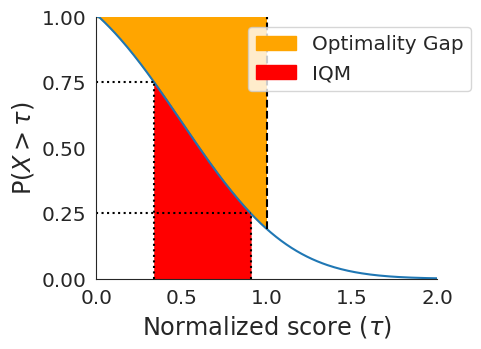

In [11]:
#@title Plot proposed aggregate metrics using performance profiles

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.4, 3.4))

mean, std = 0.5, 0.5
mult = 1.2
fn = lambda x: np.minimum(mult * (1 - scipy.stats.norm.cdf(x, loc=mean, scale=std)), 1.0)
inv_fn = lambda y: scipy.stats.norm.ppf(1 - (y / mult), loc=mean, scale=std)

x = np.linspace(0.0, 2.0 , 200)
y = fn(x)

ax.plot(x, y)


ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])

ax.tick_params(labelsize='x-large')
ax.set_xlim(left=x[0], right=x[-1])
ax.set_ylim(0.0, 1.0)

y1 = y[(y>=0.25) & (y <=0.75)]
x1 = [a for a, t in zip(x, y) if (t <= 0.75) and (t >=0.25)]

ax.fill_between(x[x<=1], 1, y[x<=1], color='orange', label='Optimality Gap')

x_25, x_75 = inv_fn(0.75), inv_fn(0.25)


ax.axhline(y=0.25, xmax=x_75/x[-1], linestyle=":", color='black')
ax.axhline(y=0.75, xmax=x_25/x[-1], linestyle=":", color='black')
ax.axvline(x=1.0, ymin=fn(1.0), linestyle="--", color='black')

ax.axvline(x=x_25, ymax=0.75, linestyle=":", color='black')
ax.axvline(x=x_75, ymax=0.25, linestyle=":", color='black')
cond = (x >= x_25) & (x <= x_75)
ax.fill_between(x[cond], y[cond], 0.0, color='red', 
                label='IQM')
ax.set_ylabel(r'P$(X > \tau)$', fontsize='xx-large')
ax.set_xlabel('Normalized score ' + r'$(\tau$)', fontsize='xx-large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(fontsize='x-large', loc='upper right', 
           fancybox=True, bbox_to_anchor=(1.13, 1.0))
plt.show()

### Atari 100K

In [13]:
#@title Atari 100k -- List of 26 Games

ATARI_100K_GAMES = [
    'Alien', 'Amidar', 'Assault', 'Asterix', 'BankHeist', 'BattleZone',
    'Boxing', 'Breakout', 'ChopperCommand', 'CrazyClimber', 'DemonAttack',
    'Freeway', 'Frostbite', 'Gopher', 'Hero', 'Jamesbond', 'Kangaroo',
    'Krull', 'KungFuMaster', 'MsPacman', 'Pong', 'PrivateEye', 'Qbert',
    'RoadRunner', 'Seaquest', 'UpNDown'
]

In [14]:
#@title Download data for Atari 100k benchmark
# !gsutil -m cp -R gs://rl-benchmark-data/atari_100k ./

In [15]:
#@title Score data for Human and random agent


RANDOM_SCORES = {
 'Alien': 227.8,
 'Amidar': 5.8,
 'Assault': 222.4,
 'Asterix': 210.0,
 'BankHeist': 14.2,
 'BattleZone': 2360.0,
 'Boxing': 0.1,
 'Breakout': 1.7,
 'ChopperCommand': 811.0,
 'CrazyClimber': 10780.5,
 'DemonAttack': 152.1,
 'Freeway': 0.0,
 'Frostbite': 65.2,
 'Gopher': 257.6,
 'Hero': 1027.0,
 'Jamesbond': 29.0,
 'Kangaroo': 52.0,
 'Krull': 1598.0,
 'KungFuMaster': 258.5,
 'MsPacman': 307.3,
 'Pong': -20.7,
 'PrivateEye': 24.9,
 'Qbert': 163.9,
 'RoadRunner': 11.5,
 'Seaquest': 68.4,
 'UpNDown': 533.4
}

HUMAN_SCORES = {
 'Alien': 7127.7,
 'Amidar': 1719.5,
 'Assault': 742.0,
 'Asterix': 8503.3,
 'BankHeist': 753.1,
 'BattleZone': 37187.5,
 'Boxing': 12.1,
 'Breakout': 30.5,
 'ChopperCommand': 7387.8,
 'CrazyClimber': 35829.4,
 'DemonAttack': 1971.0,
 'Freeway': 29.6,
 'Frostbite': 4334.7,
 'Gopher': 2412.5,
 'Hero': 30826.4,
 'Jamesbond': 302.8,
 'Kangaroo': 3035.0,
 'Krull': 2665.5,
 'KungFuMaster': 22736.3,
 'MsPacman': 6951.6,
 'Pong': 14.6,
 'PrivateEye': 69571.3,
 'Qbert': 13455.0,
 'RoadRunner': 7845.0,
 'Seaquest': 42054.7,
 'UpNDown': 11693.2
}

In [16]:
#@title Dataframe saving and reading code for Atari 100k 

def save_df(df_to_save, name, base_df_path='atari_100k'):
  base_dir = osp.join(base_df_path, name)
  os.makedirs(base_dir)
  for game in df_to_save.keys():
    file_name = osp.join(base_dir, f'{game}.json')
    with open(file_name, 'w') as f:
      df_to_save[game].to_json(f, orient='records')
    print(f'Saved {file_name}')

def read_df(name, base_df_path='atari_100k'):
  base_dir = osp.join(base_df_path, name)
  df_to_read = {}
  for game in ATARI_100K_GAMES:
    file_name = osp.join(base_dir, f'{game}.json')
    with open(file_name, 'r') as f:
      df_to_read[game] = pd.read_json(f, orient='records')
  return df_to_read

def remove_additional_evaluations(df_to_filter):
  new_df = {}
  for key in df_to_filter.keys():
    df_a = df_to_filter[key]
    df_a = df_a[df_a.index == '0'].drop(['iteration'], axis=1)
    new_df[key] = df_a
  return new_df

In [17]:
#@title Helpers for loading Atari 100k data

def create_score_dict_atari_100k(main_df, normalization=True,
                                 evaluation_key = 'eval_average_return'):
  """Creates a dictionary of scores."""
  score_dict = {}
  for key, df in main_df.items():
    score_dict[key] = df[evaluation_key].values
  if normalization:
    score_dict = score_normalization(score_dict, RANDOM_SCORES, HUMAN_SCORES)
  return score_dict
  
def get_scores(df, normalization=True, eval='Final'):
  score_dict_df = create_score_dict_atari_100k(df, normalization=normalization)
  score_matrix = convert_to_matrix(score_dict_df)
  median, mean = MEDIAN(score_matrix), MEAN(score_matrix)
  print('{}: Median: {}, Mean: {}'.format(eval, median, mean))
  return score_dict_df, score_matrix

def load_and_read_scores(algorithm_name, num_evals=None):
  print(f'Loading scores for {algorithm_name}:')
  df = read_df(algorithm_name)
  if num_evals is None:
    return get_scores(df)
  # Read multiple evals.
  final_scores_df, max_scores_df = {}, {}
  for game, game_df in df.items():
    final_scores_df[game] = game_df[game_df['iteration'] == num_evals-1]
    max_scores_df[game] = game_df.groupby('run_number').max()  
  return get_scores(final_scores_df), get_scores(max_scores_df, eval='Max')

def read_curl_scores():
  print(f'Loading scores for CURL:')
  df = pd.read_json('atari_100k/CURL_10_evals.json', orient='records')
  score_dict = {'Max': {}, 'Final': {}}
  for game in ATARI_100K_GAMES:
    game_df = df[df['game'] == game]
    score_dict['Final'][game] = game_df['HNS'].values
    score_dict['Max'][game] = game_df['Max HNS'].values
  score_matrices = {}
  for key, val in score_dict.items():
    score_matrices[key] = convert_to_matrix(val) 
    median, mean = MEDIAN(score_matrices[key]), MEAN(score_matrices[key])
    print('{}: Median: {}, Mean: {}'.format(key, median, mean))
  return (score_dict['Final'], score_matrices['Final']), (
      score_dict['Max'], score_matrices['Max'])
  
def load_json_scores(algorithm_name, base_path='atari_100k'):
  print(f'Loading scores for {algorithm_name}:')
  path = osp.join(base_path, f'{algorithm_name}.json')
  with open(path, 'r') as f:
    scores = json.load(f)
  scores = {game: np.array(val) for game, val in scores.items()}
  scores = score_normalization(scores, RANDOM_SCORES, HUMAN_SCORES)
  score_matrix = convert_to_matrix(scores)
  median, mean = MEDIAN(score_matrix), MEAN(score_matrix)
  print('{}: Median: {}, Mean: {}'.format(eval, median, mean))
  return scores, score_matrix

In [18]:
#@title Load all score dicts

(score_dict_der, score_der), (_, score_der_max) = load_and_read_scores(
    'DER', num_evals=10)
(score_dict_curl, score_curl), (_, score_curl_max) = read_curl_scores()

score_dict_otr, score_otr = load_json_scores('OTRainbow')
score_dict_drq, score_drq = load_json_scores('DrQ')
score_dict_spr, score_spr = load_json_scores('SPR')
score_dict_simple, score_simple = load_json_scores('SimPLe')
# DrQ agent but with standard epsilon values of 0.01/0.001 for training 
# and evaluation eps-greedy parameters
score_dict_drq_eps, score_drq_eps = load_json_scores('DrQ(eps)')

score_data_dict = {'CURL': score_curl, 
                    'DrQ': score_drq, 
                    'DrQ(ε)': score_drq_eps, 
                    'DER': score_der, 
                    'SimPLe': score_simple,
                    'OTR': score_otr, 
                    'SPR': score_spr}

Loading scores for DER:
Final: Median: 0.18936086395020874, Mean: 0.35030497562762936
Max: Median: 0.22508555744493525, Mean: 0.42853882584741343
Loading scores for CURL:
Max: Median: 0.15117693067850002, Mean: 0.3226518632387308
Final: Median: 0.09234861529, Mean: 0.26148856121438463
Loading scores for OTRainbow:
<built-in function eval>: Median: 0.12959095869061166, Mean: 0.21705284786438742
Loading scores for DrQ:
<built-in function eval>: Median: 0.21197693941542933, Mean: 0.36912351496348683
Loading scores for SPR:
<built-in function eval>: Median: 0.39562938291779215, Mean: 0.6157957428691673
Loading scores for SimPLe:
<built-in function eval>: Median: 0.13405558483729887, Mean: 0.3319978533732483
Loading scores for DrQ(eps):
<built-in function eval>: Median: 0.312901399063074, Mean: 0.4647412513971657


In [19]:
#@title Atari_100k Color setup

colors = sns.color_palette('colorblind')
xlabels = ['DER', 'OTR', 'CURL', 'DrQ(ε)', 'SPR', 'SimPLe', 'DrQ']
color_idxs = [0, 3, 4, 2, 1, 7, 8]
ATARI_100K_COLOR_DICT = dict(zip(xlabels, [colors[idx] for idx in color_idxs]))
atari_100k_score_dict = {key: val[:10] for key, val in score_data_dict.items()}
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [20]:
#@title Score helpers -- Subsampling


def subsample_scores(score_dict, n=5, replace=False):
  subsampled_dict = {}
  total_samples = len(score_dict[list(score_dict.keys())[0]])
  for game, scores in score_dict.items():
    indices = np.random.choice(range(total_samples), size=n, replace=replace)
    subsampled_dict[game] = scores[indices]
  return subsampled_dict

def subsample_scores_mat(score_mat, num_samples=5, replace=False):
  subsampled_dict = []
  total_samples, num_games = score_mat.shape
  subsampled_scores = np.empty((num_samples, num_games))
  for i in range(num_games):
    indices = np.random.choice(total_samples, size=num_samples, replace=replace)
    subsampled_scores[:, i] = score_mat[indices, i]
  return subsampled_scores

def subsample_seeds(score_mat, num_samples=5, replace=False):
  indices = np.random.choice(
      score_mat.shape[0], size=num_samples, replace=replace)
  return score_mat[indices]

def batch_subsample_seeds(score_mat, num_samples=5, batch_size=100,
                          replace=False):
  indices = [
    np.random.choice(score_mat.shape[0], size=num_samples, replace=replace)
    for _ in range(batch_size)
  ]
  return (score_mat[idx] for idx in indices)

def subsample_scores_mat_with_replacement(score_mat, num_samples=5):
  subsampled_dict = []
  total_samples, num_games = score_mat.shape
  indices = np.random.choice(
      total_samples, size=(num_samples, num_games), replace=True)
  col_indices =  np.expand_dims(np.arange(num_games), axis=0)
  col_indices = np.repeat(col_indices, num_samples, axis=0)
  subsampled_scores = score_mat[indices, col_indices]
  return subsampled_scores

In [21]:
#@title Aggregate computation helpers

SIZES = [3, 5, 10, 25, 50, 100]

def calc_aggregate_fn(score_data, num_samples=5, total_n=20000, 
                      aggregate_fn=MEDIAN, replace=False):
  subsampled_scores = batch_subsample_seeds(
      score_data, num_samples, batch_size=total_n, replace=replace)
  aggregates = [aggregate_fn(scores) for scores in subsampled_scores]
  return np.array(aggregates)

def calculate_aggregate_varying_sizes(score_matrix, aggregate_fn, total_n=20000,
                                      sizes=None, replace=False):
  agg_dict = {}
  if sizes is None:
    sizes = SIZES
  for size in sizes:
    agg_dict[n] = calc_aggregate_fn(score_matrix, num_samples=size, aggregate_fn=aggregate_fn,
                                    total_n=total_n, replace=replace)
    print('Mean Aggregate: {}'.format(np.mean(agg_dict[n])))
  return agg_dict

def CI(bootstrap_dist, stat_val=None, alpha=0.05, is_pivotal=False):
    """
    Get the bootstrap confidence interval for a given distribution.
    Args:
      bootstrap_distribution: numpy array of bootstrap results.
      stat_val: The overall statistic that this method is attempting to
        calculate error bars for. Default is None.
      alpha: The alpha value for the confidence intervals.
      is_pivotal: if true, use the pivotal (reverse percentile) method. 
        If false, use the percentile method.
    Returns:
      (low, high): The lower and upper limit for `alpha` x 100% CIs.
      val: The median value of the bootstrap distribution if `stat_val` is None
        else `stat_val`.
    """
    # Adapted from https://pypi.org/project/bootstrapped
    if is_pivotal:
      assert stat_val is not None, 'Please pass the statistic for a pivotal'
      'confidence interval' 
      low = 2 * stat_val - np.percentile(bootstrap_dist, 100 * (1 - alpha / 2.))
      val = stat_val
      high = 2 * stat_val - np.percentile(bootstrap_dist, 100 * (alpha / 2.))
    else:
      low = np.percentile(bootstrap_dist, 100 * (alpha / 2.))
      val = np.percentile(bootstrap_dist, 50)
      high = np.percentile(bootstrap_dist, 100 * (1 - alpha / 2.))
    return (low, high), val

In [29]:
np.shape(atari_100k_score_dict['CURL'])
np.shape(score_simple)


(5, 26)

INFO:absl:Calculating estimates for CURL ...
INFO:absl:Calculating estimates for DrQ ...
INFO:absl:Calculating estimates for DrQ(ε) ...
INFO:absl:Calculating estimates for DER ...
INFO:absl:Calculating estimates for SimPLe ...
INFO:absl:Calculating estimates for OTR ...
INFO:absl:Calculating estimates for SPR ...


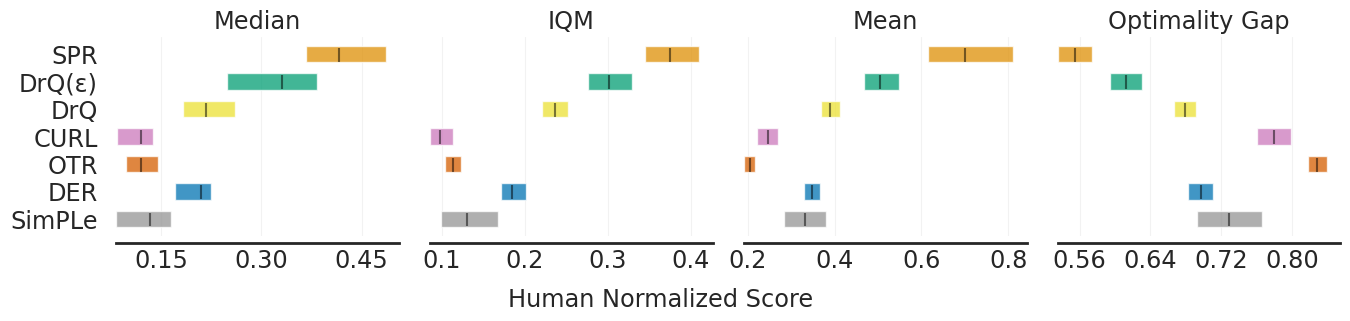

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'a', 'c', 'd', 'e', 'eight', 'epsilon', 'five', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 68

'atari_100k_aggregates.pdf'

In [20]:
#@title Aggregates on Atari 100K (with 10 runs)


aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    atari_100k_score_dict, aggregate_func, reps=50000)

algorithms = ['SimPLe', 'DER', 'OTR', 'CURL', 'DrQ', 'DrQ(ε)', 'SPR']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    colors=ATARI_100K_COLOR_DICT,
    xlabel_y_coordinate=-0.16,
    xlabel='Human Normalized Score')
plt.show()
save_fig(fig, 'atari_100k_aggregates')

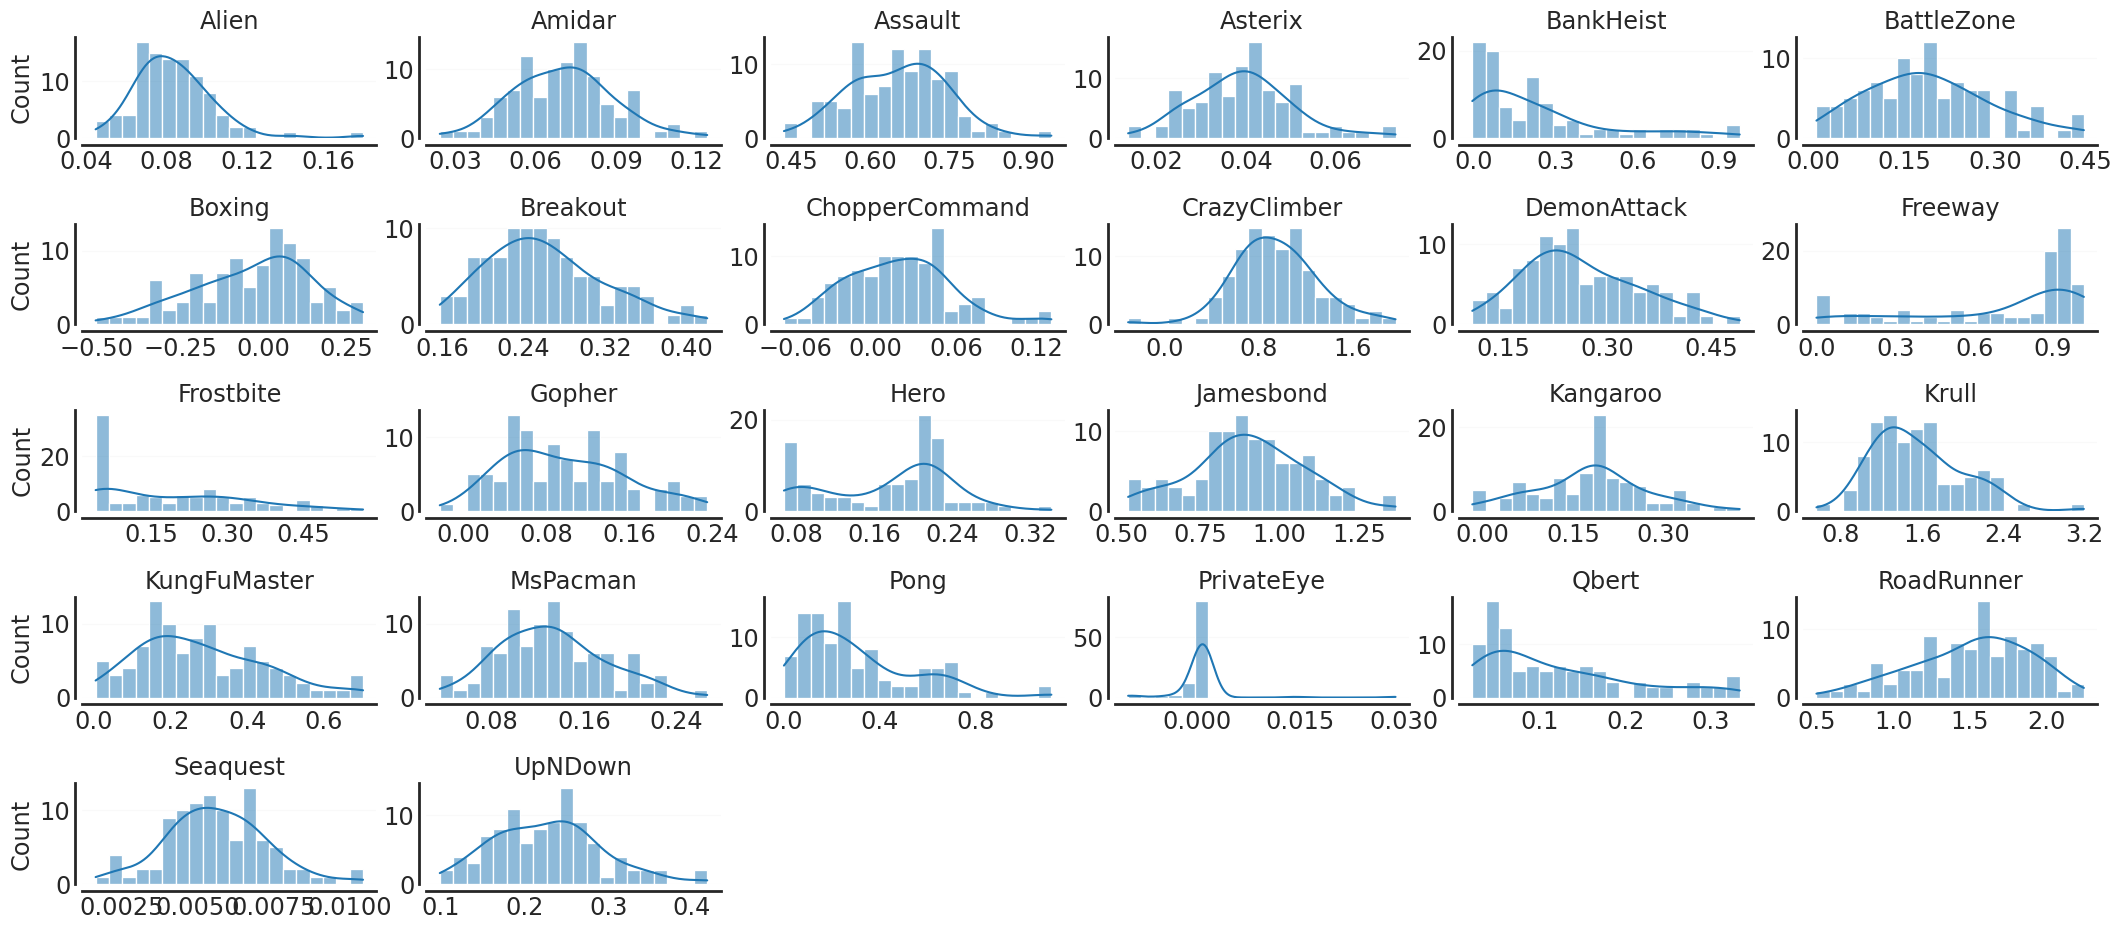

In [21]:
#@title DER Scores Distribution plots

fig = plot_score_hist(score_der, bins=20, N=6, figsize=(26, 11))
fig.subplots_adjust(hspace=0.85, wspace=0.17)
plt.show()

In [22]:
from scipy.stats.stats import find_repeats
#@title Calculate score distributions and average score distributions for for Atari 100k

algorithms = ['SimPLe', 'DER', 'OTR', 'CURL', 'DrQ(ε)', 'SPR']
score_dict = {key: score_data_dict[key][:10] for key in algorithms}
ATARI_100K_TAU = np.linspace(0.0, 2.0, 201)
# Higher value of reps corresponds to more accurate estimates but are slower
# to computed. `reps` corresponds to number of bootstrap resamples.
reps = 2000

score_distributions, score_distributions_cis = rly.create_performance_profile(
    score_dict, ATARI_100K_TAU, reps=reps)
avg_score_distributions, avg_score_distributions_cis = rly.create_performance_profile(
    score_dict, ATARI_100K_TAU, use_score_distribution=False, reps=reps)

/tmp/ipykernel_6468/3924000286.py:1: DeprecationWarning: Please use `find_repeats` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import find_repeats
INFO:absl:Calculating estimates for SimPLe ...
INFO:absl:Calculating estimates for DER ...
INFO:absl:Calculating estimates for OTR ...
INFO:absl:Calculating estimates for CURL ...
INFO:absl:Calculating estimates for DrQ(ε) ...
INFO:absl:Calculating estimates for SPR ...
INFO:absl:Calculating estimates for SimPLe ...
INFO:absl:Calculating estimates for DER ...
INFO:absl:Calculating estimates for OTR ...
INFO:absl:Calculating estimates for CURL ...
INFO:absl:Calculating estimates for DrQ(ε) ...
INFO:absl:Calculating estimates for SPR ...


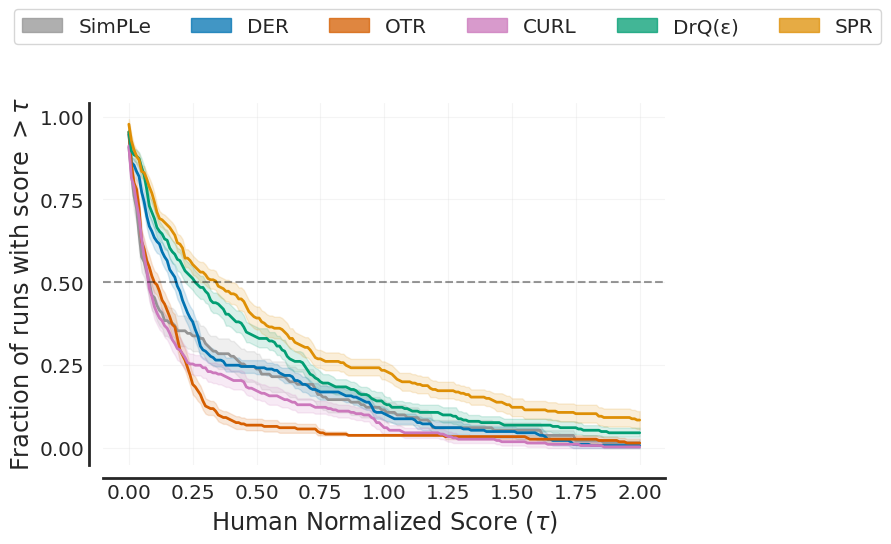

In [23]:
#@title Plot performance profiles (score distributions)

fig, ax = plt.subplots(ncols=1, figsize=(7.25, 4.7))

plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=ax)

ax.axhline(0.5, ls='--', color='k', alpha=0.4)
fake_patches = [mpatches.Patch(color=ATARI_100K_COLOR_DICT[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=len(algorithms), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.6, 1.1))

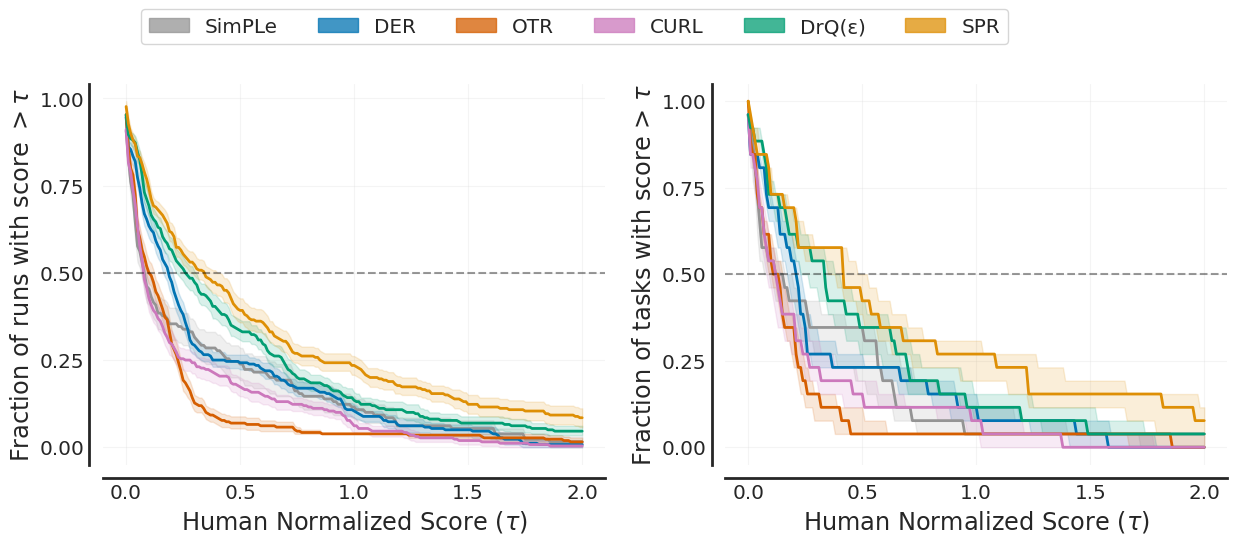

In [24]:
#@title Plot performance profiles (score distributions) and contrast with average score distribution
fig, axes = plt.subplots(ncols=2, figsize=(14.5, 4.7))

plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=axes[0])


plot_utils.plot_performance_profiles(
  avg_score_distributions, ATARI_100K_TAU,
  performance_profile_cis=avg_score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  ylabel=r'Fraction of tasks with score > $\tau$',
  labelsize='xx-large',
  ax=axes[1])

axes[0].axhline(0.5, ls='--', color='k', alpha=0.4)
axes[1].axhline(0.5, ls='--', color='k', alpha=0.4)

fake_patches = [mpatches.Patch(color=ATARI_100K_COLOR_DICT[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=len(algorithms), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.45, 1.1))
fig.subplots_adjust(top=0.92, wspace=0.24)

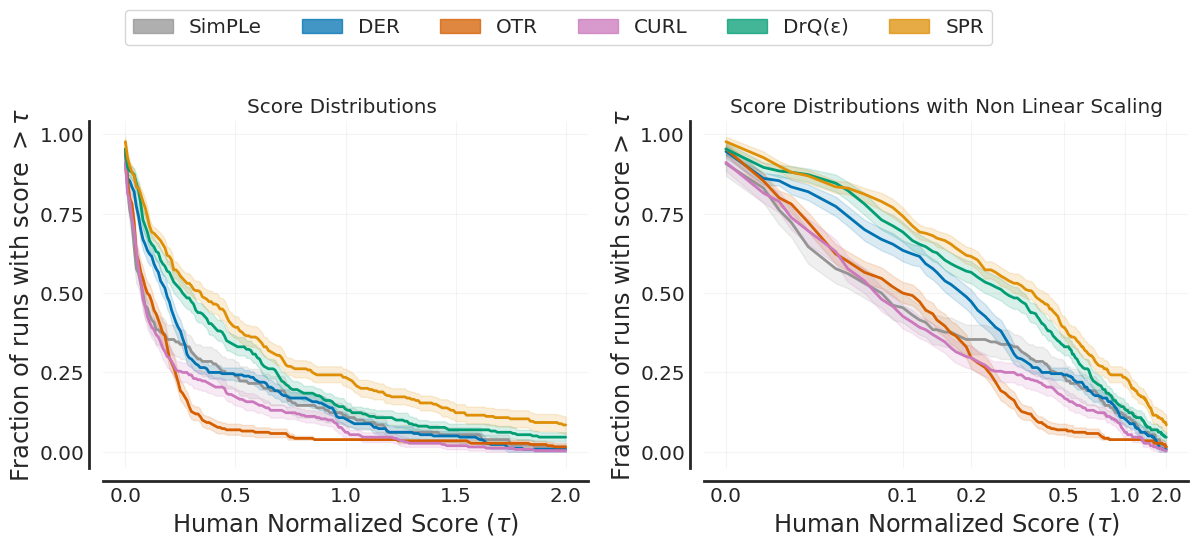

In [25]:
#@title Performance profiles for Atari 100K 

fig, ax = plt.subplots(ncols=2, figsize=(7*2, 4.5))
algorithms = ['SimPLe', 'DER', 'OTR', 'CURL', 'DrQ(ε)', 'SPR']
plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  labelsize='xx-large',
  ax=ax[0])
ax[0].set_title('Score Distributions ', size='x-large')

xticks = [0.0, 0.1, 0.2, 0.5, 1.0, 2.0]
plot_utils.plot_performance_profiles(
  score_distributions, ATARI_100K_TAU,
  performance_profile_cis=score_distributions_cis,
  colors=ATARI_100K_COLOR_DICT,
  xlabel=r'Human Normalized Score $(\tau)$',
  ylabel=r'Fraction of runs with score > $\tau$',
  labelsize='xx-large',
  use_non_linear_scaling=True,
  xticks=xticks,
  ax=ax[1])
ax[1].set_title('Score Distributions with Non Linear Scaling', size='x-large')

fake_patches = [mpatches.Patch(color=ATARI_100K_COLOR_DICT[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=len(algorithms), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.45, 1.15))
fig.subplots_adjust(wspace=0.24)

In [26]:
#@title Compute Probability of Improvement for all comparisons on Atari 100k

algorithms = ['SimPLe', 'DER', 'OTR', 'CURL', 'DrQ(ε)', 'SPR']
our_algorithm = 'SPR' #@param ['SimPLe', 'DER', 'OTR', 'CURL', 'DrQ(ε)', 'SPR']
all_pairs =  {}
for alg in (algorithms):
  if alg == our_algorithm:
    continue
  pair_name = f'{our_algorithm}_{alg}'
  all_pairs[pair_name] = (
      atari_100k_score_dict[our_algorithm], atari_100k_score_dict[alg]) 

probabilities, probability_cis = {}, {}
reps = 1000
probabilities, probability_cis = rly.get_interval_estimates(
    all_pairs, metrics.probability_of_improvement, reps=reps)

INFO:absl:Calculating estimates for SPR_SimPLe ...
INFO:absl:Calculating estimates for SPR_DER ...
INFO:absl:Calculating estimates for SPR_OTR ...
INFO:absl:Calculating estimates for SPR_CURL ...
INFO:absl:Calculating estimates for SPR_DrQ(ε) ...


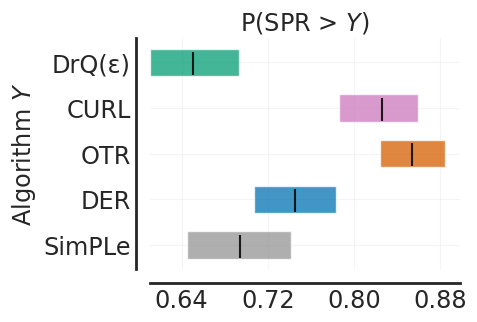

In [27]:
#@title Plot probabilities of improvement P(X > Y) with 95% CIs

fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
  _, alg1 = alg_pair.split('_')
  algorithm_labels.append(alg1)
  (l, u) = probability_cis[alg_pair]
  ax.barh(y=i, width=u-l, height=h, 
          left=l, color=ATARI_100K_COLOR_DICT[alg1], 
          alpha=0.75)
  ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)


ax.set_title(fr'P({alg} > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
fig.subplots_adjust(wspace=0.25, hspace=0.45)

### Procgen

In [28]:
#@title Download ProcGen data

#!gsutil -m cp -R gs://rl-benchmark-data/procgen ./

: 

: 

In [ ]:
#@title Procgen Constants and Normalization

EASY_GAME_RANGES = {
    'coinrun': [5, 10],
    'starpilot': [2.5, 64],
    'caveflyer': [3.5, 12],
    'dodgeball': [1.5, 19],
    'fruitbot': [-1.5, 32.4],
    'chaser': [.5, 13],
    'miner': [1.5, 13],
    'jumper': [1, 10],
    'leaper': [1.5, 10],
    'maze': [5, 10],
    'bigfish': [1, 40],
    'heist': [3.5, 10],
    'climber': [2, 12.6],
    'plunder': [4.5, 30],
    'ninja': [3.5, 10],
    'bossfight': [.5, 13],
}

PROCGEN_ENVS = [
 'bigfish',
 'bossfight',
 'caveflyer',
 'chaser',
 'climber',
 'coinrun',
 'dodgeball',
 'fruitbot',
 'heist',
 'jumper',
 'leaper',
 'maze',
 'miner',
 'ninja',
 'plunder',
 'starpilot'
]

def score_normalization_procgen(res_dict, min_scores, max_scores):
  games = res_dict.keys()
  norm_scores = {}
  for game, scores in res_dict.items():
    norm_scores[game] = (np.array(scores) - min_scores[game])/(max_scores[game] - min_scores[game])
  return norm_scores

MIN_PROCGEN_SCORES = {g: EASY_GAME_RANGES[g][0] for g in PROCGEN_ENVS}
MAX_PROCGEN_SCORES = {g: EASY_GAME_RANGES[g][1] for g in PROCGEN_ENVS}

min_max_procgen_normalize = lambda scores: score_normalization_procgen(
    scores, MIN_PROCGEN_SCORES, MAX_PROCGEN_SCORES)

In [ ]:
#@title Create normalized score dictionaries for ProcGen

filename = 'procgen/procgen_data.json'
with open(filename, 'r') as f:
  procgen_data_dict = json.load(f)

# Create PPO Normalization
MEAN_PPO_SCORES = {key: np.mean(val) for key, val in procgen_data_dict['PPO'].items()}
ZERO_SCORES = {key: 0.0 for key in PROCGEN_ENVS}
ppo_procgen_normalize = lambda scores: score_normalization_procgen(
    scores, ZERO_SCORES, MEAN_PPO_SCORES)

norm_procgen_data = {'Min-Max': {}, 'PPO': {}}
algorithms = ['PPO', 'MixReg', 'UCB-DrAC', 'PLR', 'PPG', 'IDAAC']
for method in algorithms:
  scores = procgen_data_dict[method]
  norm_procgen_data['Min-Max'][method] = convert_to_matrix(
      min_max_procgen_normalize(scores))
  norm_procgen_data['PPO'][method] = convert_to_matrix(
      ppo_procgen_normalize(scores))

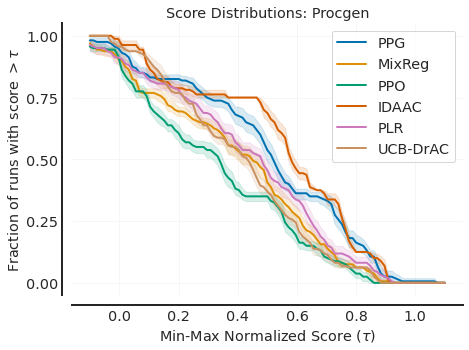

In [ ]:
#@title Calculate and plot performance profiles on ProcGen (Min-Max)

procgen_tau = np.linspace(-0.1, 1.1, 101)
procgen_profiles, procgen_profile_cis = rly.create_performance_profile(
    norm_procgen_data['Min-Max'], procgen_tau, reps=2000)


fig, ax = plt.subplots(figsize=(7, 5))
algorithms = ['PPO', 'MixReg', 'UCB-DrAC', 'PLR', 'PPG', 'IDAAC']
plot_utils.plot_performance_profiles(
  procgen_profiles, procgen_tau,
  performance_profile_cis=procgen_profile_cis,  
  xlabel=r'Min-Max Normalized Score $(\tau)$',
  legend=True, ax=ax)
ax.set_title('Score Distributions: Procgen', size='x-large')
plt.show()

INFO:absl:Calculating estimates for PPO ...
INFO:absl:Calculating estimates for MixReg ...
INFO:absl:Calculating estimates for UCB-DrAC ...
INFO:absl:Calculating estimates for PLR ...
INFO:absl:Calculating estimates for PPG ...
INFO:absl:Calculating estimates for IDAAC ...


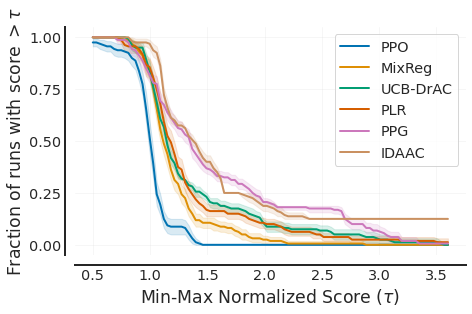

In [ ]:
#@title Calculate and plot performance profiles on ProcGen (PPO normalized)

procgen_tau = np.linspace(0.5, 3.6, 101)
procgen_profiles, procgen_profile_cis = rly.create_performance_profile(
    norm_procgen_data['PPO'], procgen_tau, reps=2000)


fig, ax = plt.subplots(figsize=(7, 4.2))
plot_utils.plot_performance_profiles(
  procgen_profiles, procgen_tau,
  performance_profile_cis=procgen_profile_cis,  
  xlabel=r'Min-Max Normalized Score $(\tau)$',
  labelsize='xx-large',
  legend=True, ax=ax)
# ax.set_title('Score Distributions: Procgen', size='x-large')
plt.show()

INFO:absl:Calculating estimates for PPG ...
INFO:absl:Calculating estimates for MixReg ...
INFO:absl:Calculating estimates for PPO ...
INFO:absl:Calculating estimates for IDAAC ...
INFO:absl:Calculating estimates for PLR ...
INFO:absl:Calculating estimates for UCB-DrAC ...


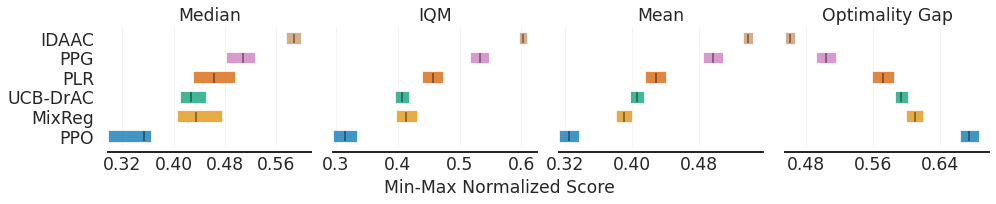

In [ ]:
#@title Aggregate Metrics (Min-Max Normalized Score)

procgen_scores = norm_procgen_data['Min-Max']
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    procgen_scores, aggregate_func, reps=50000)


algorithms = ['PPO', 'MixReg', 'UCB-DrAC', 'PLR', 'PPG', 'IDAAC']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.16,
    xlabel='Min-Max Normalized Score')

plt.show()

INFO:absl:Calculating estimates for PPG ...
INFO:absl:Calculating estimates for MixReg ...
INFO:absl:Calculating estimates for PPO ...
INFO:absl:Calculating estimates for IDAAC ...
INFO:absl:Calculating estimates for PLR ...
INFO:absl:Calculating estimates for UCB-DrAC ...


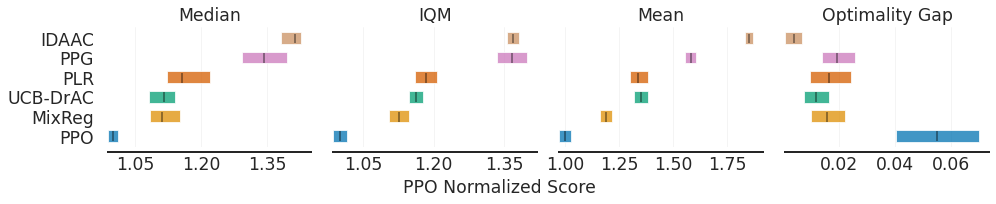

In [ ]:
#@title Aggregate Metrics (PPO Normalized Score)


procgen_ppo_scores = norm_procgen_data['PPO']
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    procgen_ppo_scores, aggregate_func, reps=50000)


algorithms = ['PPO', 'MixReg', 'UCB-DrAC', 'PLR', 'PPG', 'IDAAC']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.16,
    xlabel='PPO Normalized Score')

plt.show()

In [ ]:
#@title Compute Probability of Improvement

pairs = [['IDAAC', 'PPG'], ['IDAAC', 'UCB-DrAC'], ['IDAAC', 'PPO'],
         ['PPG', 'PPO'], ['UCB-DrAC', 'PLR'], 
         ['PLR', 'MixReg'], ['UCB-DrAC', 'MixReg'],  ['MixReg', 'PPO']]

procgen_algorithm_pairs = {}
for pair in pairs[::-1]:
  d1 = norm_procgen_data['Min-Max'][pair[0]]
  d2 = norm_procgen_data['Min-Max'][pair[1]]
  # d_concat = np.concatenate((d1, d2), axis=-1)
  procgen_algorithm_pairs['_'.join(pair)] = (d1, d2)

probabilities, probability_cis = rly.get_interval_estimates(
    procgen_algorithm_pairs, metrics.probability_of_improvement, reps=2000)

INFO:absl:Calculating estimates for MixReg_PPO ...
INFO:absl:Calculating estimates for UCB-DrAC_MixReg ...
INFO:absl:Calculating estimates for PLR_MixReg ...
INFO:absl:Calculating estimates for UCB-DrAC_PLR ...
INFO:absl:Calculating estimates for PPG_PPO ...
INFO:absl:Calculating estimates for IDAAC_PPO ...
INFO:absl:Calculating estimates for IDAAC_UCB-DrAC ...
INFO:absl:Calculating estimates for IDAAC_PPG ...


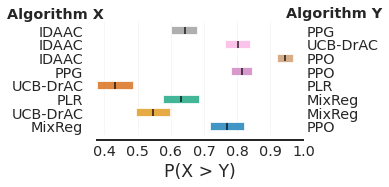

In [ ]:
#@title Plot Probability of improvement

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.1))
h = 0.6

ax2 = ax.twinx()
colors = sns.color_palette('colorblind')

for i, (pair, p) in enumerate(probabilities.items()):  
  (l, u), p  = probability_cis[pair], p

  ax.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.75, label=pair[0])
  ax2.barh(y=i, width=u-l, height=h, 
          left=l, color=colors[i], 
          alpha=0.0, label=pair[1])
  ax.vlines(x=p, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
  

ax.set_yticks(list(range(len(pairs))))
ax2.set_yticks(range(len(pairs)))
pairs = [x.split('_') for x in probabilities.keys()]
ax2.set_yticklabels([pair[1] for pair in pairs], fontsize='large')
ax.set_yticklabels([pair[0] for pair in pairs], fontsize='large')
ax2.set_ylabel('Algorithm Y', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_ylabel('Algorithm X', fontweight='bold', rotation='horizontal', fontsize='x-large')
ax.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.yaxis.set_label_coords(-0.2, 1.0)
ax2.yaxis.set_label_coords(1.15, 1.13)
decorate_axis(ax, wrect=5)
decorate_axis(ax2, wrect=5)
       
ax.tick_params(axis='both', which='major', labelsize='x-large')
ax2.tick_params(axis='both', which='major', labelsize='x-large')
ax.set_xlabel('P(X > Y)', fontsize='xx-large')
ax.grid(axis='x', alpha=0.2)
plt.subplots_adjust(wspace=0.05)
ax.spines['left'].set_visible(False)
ax2.spines['left'].set_visible(False)


plt.show()

### DM Control

In [ ]:
#@title Download DM control data
#!gsutil -m cp -R gs://rl-benchmark-data/dm_control ./

Copying gs://rl-benchmark-data/dm_control/DrQ.json...
Copying gs://rl-benchmark-data/dm_control/Dreamer.json...
Copying gs://rl-benchmark-data/dm_control/SAC+AE.json...
Copying gs://rl-benchmark-data/dm_control/PISAC.json...
Copying gs://rl-benchmark-data/dm_control/RAD_3_seeds.json...
Copying gs://rl-benchmark-data/dm_control/RAD.json...
Copying gs://rl-benchmark-data/dm_control/SLAC.json...
/ [7/7 files][ 10.0 KiB/ 10.0 KiB] 100% Done                                    
Operation completed over 7 objects/10.0 KiB.                                     


In [ ]:
#@title Load DMC data

DMC_ENVS = sorted(['ball_in_cup_catch', 'cartpole_swingup', 'cheetah_run',
                   'finger_spin', 'reacher_easy', 'walker_walk'])

def read_dmc_json(algorithm, steps = '100k'):
  assert steps in ['100k', '500k']
  with open(f'dm_control/{algorithm}.json', 'r') as f:
    out = json.load(f)
  out = out[steps]
  print(algorithm, steps, {k: np.round(np.mean(v), 1) for k, v in out.items()})
  return {k: np.round(v, 1) for k, v in out.items()}

algs = ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']
dmc_scores = {}
for steps in ['100k', '500k']:
  dmc_scores[steps] = {alg : convert_to_matrix(read_dmc_json(alg, steps)) 
                     for alg in algs}
normalized_dmc_scores = {}
for steps in ['100k', '500k']:
  normalized_dmc_scores[steps] = {alg: scores/1000 for alg, scores in dmc_scores[steps].items()}

SLAC 100k {'finger_spin': 951.2, 'cartpole_swingup': 327.5, 'reacher_easy': 342.5, 'cheetah_run': 413.5, 'walker_walk': 529.0, 'ball_in_cup_catch': 917.6}
SAC+AE 100k {'finger_spin': 747.0, 'cartpole_swingup': 276.6, 'reacher_easy': 225.1, 'cheetah_run': 240.6, 'walker_walk': 395.9, 'ball_in_cup_catch': 338.4}
Dreamer 100k {'ball_in_cup_catch': 797.7, 'cartpole_swingup': 786.6, 'cheetah_run': 422.6, 'finger_spin': 405.9, 'reacher_easy': 373.1, 'walker_walk': 533.1}
PISAC 100k {'finger_spin': 957.4, 'ball_in_cup_catch': 933.4, 'cartpole_swingup': 815.9, 'cheetah_run': 459.9, 'reacher_easy': 757.8, 'walker_walk': 513.9}
RAD 100k {'cartpole_swingup': 632.9, 'cheetah_run': 419.1, 'ball_in_cup_catch': 488.0, 'reacher_easy': 385.3, 'walker_walk': 391.2, 'finger_spin': 729.9}
DrQ 100k {'finger_spin': 901.4, 'cartpole_swingup': 759.4, 'reacher_easy': 600.4, 'cheetah_run': 361.0, 'walker_walk': 633.6, 'ball_in_cup_catch': 913.8}
SLAC 500k {'finger_spin': 983.3, 'cartpole_swingup': 792.7, 'reach

In [ ]:
#@title setup colors

colors = sns.color_palette('colorblind')
algs = ['SLAC', 'SAC+AE', 'PISAC', 'RAD', 'DrQ', 'CURL', 
        'SUNRISE', 'Dreamer', 'CURL-D2RL', 'PlaNet']
color_idxs = [0, 3, 4, 2, 1] + list(range(9, 4, -1))
DMC_COLOR_DICT = dict(zip(algs, [colors[idx] for idx in color_idxs]))

In [ ]:
#@title Calculate score distributions on DM Control
dmc_tau = np.linspace(0.0, 1.0, 21)
perf_prof_dmc = {}
perf_prof_dmc_cis = {}
for steps in normalized_dmc_scores.keys():
  perf_prof_dmc[steps], perf_prof_dmc_cis[steps] = rly.create_performance_profile(
      normalized_dmc_scores[steps], dmc_tau, reps=5000)

INFO:absl:Calculating estimates for SLAC ...
INFO:absl:Calculating estimates for SAC+AE ...
INFO:absl:Calculating estimates for Dreamer ...
INFO:absl:Calculating estimates for PISAC ...
INFO:absl:Calculating estimates for RAD ...
INFO:absl:Calculating estimates for DrQ ...
INFO:absl:Calculating estimates for SLAC ...
INFO:absl:Calculating estimates for SAC+AE ...
INFO:absl:Calculating estimates for Dreamer ...
INFO:absl:Calculating estimates for PISAC ...
INFO:absl:Calculating estimates for RAD ...
INFO:absl:Calculating estimates for DrQ ...


Text(-0.05, 0.1, 'Fraction of runs with score $> \\tau$')

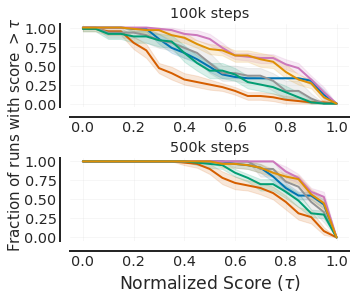

In [ ]:
#@title Performance profiles on DM Control

algorithms = ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 4))
color_dict = dict(zip(algorithms, sns.color_palette('colorblind')))
steps = '500k'
for i, steps in enumerate(['100k', '500k']):
  plot_utils.plot_performance_profiles(
    perf_prof_dmc[steps], dmc_tau,
    performance_profile_cis=perf_prof_dmc_cis[steps], 
    colors=DMC_COLOR_DICT,
    ylabel='',
    xlabel=r'Normalized Score $(\tau)$',
    labelsize='xx-large',
    ax=ax[i])
  ax[i].set_title(f'{steps} steps', size='x-large')
ax[0].set_xlabel('')
fig.subplots_adjust(hspace=0.6)
fig.text(x=-0.05, y=0.1, s=r'Fraction of runs with score $> \tau$', rotation=90, size=15)

In [ ]:
save_fig(fig, 'dmc_perf_profile_updated')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'dmc_perf_profile_updated.pdf'

In [ ]:
#@title Rank Computation Helpers

def subsample_scores_mat(score_mat, num_samples=5, replace=False):
  subsampled_dict = []
  total_samples, num_games = score_mat.shape
  subsampled_scores = np.empty((num_samples, num_games))
  for i in range(num_games):
    indices = np.random.choice(total_samples, size=num_samples, replace=replace)
    subsampled_scores[:, i] = score_mat[indices, i]
  return subsampled_scores

def get_rank_matrix(score_dict, n=100000, algorithms=None):
  arr = []
  if algorithms is None:
    algorithms = sorted(score_dict.keys())
  print(f'Using algorithms: {algorithms}')
  for alg in algorithms:
    arr.append(subsample_scores_mat(
        score_dict[alg], num_samples=n, replace=True))
  X = np.stack(arr, axis=0)
  num_algs, _, num_tasks = X.shape
  all_mat = []
  for task in range(num_tasks):
    # Sort based on negative scores as rank 0 corresponds to minimum value,
    # rank 1 corresponds to second minimum value when using lexsort.
    task_x = -X[:, :, task]
    # This is done to randomly break ties.
    rand_x = np.random.random(size=task_x.shape)
    # Last key is the primary key, 
    indices = np.lexsort((rand_x, task_x), axis=0)
    mat = np.zeros((num_algs, num_algs))
    for rank in range(num_algs):
      cnts = collections.Counter(indices[rank])
      mat[:, rank] = np.array([cnts[i]/n for i in range(num_algs)])
    all_mat.append(mat)
  all_mat = np.stack(all_mat, axis=0)
  return all_mat

In [ ]:
#@title Test where Algo 4 > 3 > 2 > 1 > 0.
dmc_score_dict = dmc_scores['100k']

sdc = {k : dmc_score_dict['DrQ'] + k*100 for k in range(5)}
all_ranks = get_rank_matrix(sdc, 100000)
mean_ranks = np.mean(all_ranks, axis=0)
mean_ranks

Using algorithms: [0, 1, 2, 3, 4]


array([[0.00143333, 0.01544   , 0.06056167, 0.20258   , 0.719985  ],
       [0.01167167, 0.05728833, 0.192265  , 0.55055333, 0.18822167],
       [0.04721333, 0.19652833, 0.530785  , 0.15913833, 0.066335  ],
       [0.19102   , 0.57087333, 0.15107167, 0.06607833, 0.02095667],
       [0.74866167, 0.15987   , 0.06531667, 0.02165   , 0.00450167]])

In [ ]:
#@title Compute Ranks

mean_ranks_all = {}
all_ranks_individual = {}
for key in ['100k', '500k']:
  dmc_score_dict = dmc_scores[key]
  algs = ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']
  all_ranks = get_rank_matrix(dmc_score_dict, 200000, algorithms=algs)
  mean_ranks_all[key] = np.mean(all_ranks, axis=0)
  all_ranks_individual[key] = all_ranks

Using algorithms: ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']
Using algorithms: ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']


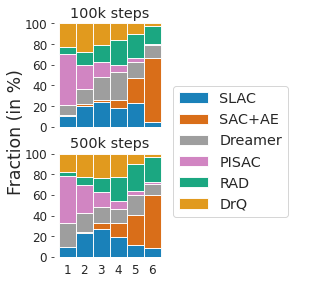

In [ ]:
#@title Plot aggregate ranks

keys = algs
labels = list(range(1, len(keys)+1))
width = 1.0       # the width of the bars: can also be len(x) sequence

# fig, axes = plt.subplots(ncols=2, figsize=(2.9 * 2, 3.6))
fig, axes = plt.subplots(nrows=2, figsize=(2, 2.3 * 2))



for main_idx, main_key in enumerate(['100k', '500k']):
  ax = axes[main_idx]
  mean_ranks = mean_ranks_all[main_key]
  bottom = np.zeros_like(mean_ranks[0])
  for i, key in enumerate(algs):
    label = key if main_idx == 0 else None
    ax.bar(labels, mean_ranks[i], width, label=label, 
          color=DMC_COLOR_DICT[key], bottom=bottom, alpha=0.9)
    bottom += mean_ranks[i]

  yticks = np.array(range(0, 101, 20))
  ax.set_yticklabels(yticks, size='large')
  # if main_idx == 0:
  #   ax.set_ylabel('Fraction (in %)', size='x-large')
  #   yticks = np.array(range(0, 101, 20))
  #   ax.set_yticklabels(yticks, size='large')
  # else:
  #   ax.set_yticklabels([])
    
  ax.set_yticks(yticks * 0.01)
  # ax.set_xlabel('Ranking', size='x-large')
  if main_idx != 0:
    ax.set_xticks(labels)
  else:
    ax.set_xticks([])
  ax.set_xticklabels(labels, size='large')
  ax.set_title(main_key + ' steps', size='x-large', y=0.95)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  # left = True if main_idx == 0 else False
  left= True
  ax.tick_params(axis='both', which='both', bottom=False, top=False,
                  left=left, right=False, labeltop=False,
                  labelbottom=True, labelleft=left, labelright=False)

fig.legend(loc='center right', fancybox=True, ncol=1, fontsize='x-large', bbox_to_anchor=(2.05, 0.40))
fig.subplots_adjust(top=0.72, wspace=0.0, bottom=0)
fig.text(x=-0.2, y=0.2, s='Fraction (in %)', rotation=90, size='xx-large')
plt.show()

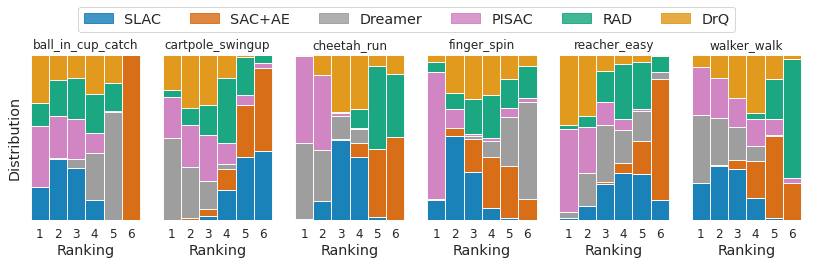

In [ ]:
#@title Plot individual ranks on 6 tasks

keys = algs
labels = list(range(1, len(keys)+1))
width = 1.0       # the width of the bars: can also be len(x) sequence

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(14, 3.5))
all_ranks = all_ranks_individual['500k']
for task in range(6):
  bottom = np.zeros_like(mean_ranks[0])
  for i, key in enumerate(keys):
    ranks = all_ranks[task]
    ax = axes[task]
    ax.bar(labels, ranks[i], width, color=DMC_COLOR_DICT[key], 
           bottom=bottom, alpha=0.9)
    bottom += ranks[i]
    # for label in labels:
      # perc = int(np.round(mean_ranks[i][label-1] * 100))
      # ax.text(s= str(perc) + '%', x=label-0.25, y=bottom[label-1] - perc/200,
      #         color="w", verticalalignment="center", 
      #         horizontalalignment="left", size=10)
    ax.set_title(DMC_ENVS[task], fontsize='large')

  # if task == 0:
  #   ax.set_ylabel('Fraction (in %)', size='x-large')
  #   yticks = np.array(range(0, 101, 20))
  #   ax.set_yticklabels(yticks, size='large')
  # else:
  #   ax.set_yticklabels([])

  if task == 0:
    ax.set_ylabel('Distribution', size='x-large')
  ax.set_xlabel('Ranking', size='x-large')
  ax.set_xticks(labels)
  ax.set_ylim(0, 1)
  ax.set_xticklabels(labels, size='large')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.tick_params(axis='both', which='both', bottom=False, top=False,
                  left=False, right=False, labeltop=False,
                  labelbottom=True, labelleft=False, labelright=False)

fake_patches = [mpatches.Patch(color=DMC_COLOR_DICT[m], alpha=0.75) 
                for m in keys]
legend = fig.legend(fake_patches, keys, loc='upper center', 
                    fancybox=True, ncol=len(keys), fontsize='x-large')
fig.subplots_adjust(top=0.78, wspace=0.1, hspace=0.05)
plt.show()

In [ ]:
#@title Calculate bootstrap CIs for mean scores

mean_func = lambda x: np.array([MEAN(x)])
all_mean_CIs, score_dmc_all = {}, {}
for steps in ['100k', '500k']:
  score_dmc_all[steps], all_mean_CIs[steps] = rly.get_interval_estimates(
      normalized_dmc_scores[steps], mean_func, reps=50000)

INFO:absl:Calculating estimates for SLAC ...
INFO:absl:Calculating estimates for SAC+AE ...
INFO:absl:Calculating estimates for Dreamer ...
INFO:absl:Calculating estimates for PISAC ...
INFO:absl:Calculating estimates for RAD ...
INFO:absl:Calculating estimates for DrQ ...
INFO:absl:Calculating estimates for SLAC ...
INFO:absl:Calculating estimates for SAC+AE ...
INFO:absl:Calculating estimates for Dreamer ...
INFO:absl:Calculating estimates for PISAC ...
INFO:absl:Calculating estimates for RAD ...
INFO:absl:Calculating estimates for DrQ ...


In [ ]:
#@title Manually list scores

means_100k, means_500k = {}, {}
stds_100k, stds_500k = {}, {}
ENVS = ['finger_spin', 'cartpole_swingup', 'reacher_easy', 
        'cheetah_run' , 'walker_walk', 'ball_in_cup_catch']

# CURL https://arxiv.org/pdf/2004.04136.pdf
means_500k['CURL'] = [926, 841, 929, 518, 902, 959]
means_100k['CURL'] = [767, 582, 538, 299, 403, 769]

stds_500k['CURL'] = [45, 45, 44, 28, 43, 27]
stds_100k['CURL'] = [56, 146, 233, 48, 24, 43]

# SUNRISE
means_500k['SUNRISE'] = [983, 876, 982, 678, 953, 969]
means_100k['SUNRISE'] = [905, 591, 722, 413, 667, 663]

stds_500k['SUNRISE'] = [1, 4, 3, 46, 13, 5]
stds_100k['SUNRISE'] = [57, 55, 50, 35, 147, 241]

# CURL-D2RL
means_100k['CURL-D2RL'] = [837, 836, 754, 253, 540, 880]
means_500k['CURL-D2RL'] = [970, 859, 929, 386, 931, 955]

stds_500k['CURL-D2RL'] = [14, 8, 62, 115, 24, 15]
stds_100k['CURL-D2RL'] = [18, 34, 168, 57, 153, 48]

In [ ]:
#@title CIs using standard deviation for manually listed scores

# See: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_CI(mean, std, n, confidence=0.95):
  se = std / np.sqrt(n)
  h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
  return np.array([mean-h, mean+h])/1000

ci_algs = {'100k': {}, '500k': {}}
mean_algs = {'100k': {}, '500k': {}}
for alg in ['CURL', 'SUNRISE', 'CURL-D2RL']:
  if alg == 'SUNRISE':
    num_seeds = 5
  else:
    num_seeds = 10
  for steps in ['100k', '500k']:
    if steps == '100k':
      std = np.sqrt(np.mean(np.square(stds_100k[alg])))
      mean = np.mean(means_100k[alg])
    else:
      std = np.sqrt(np.mean(np.square(stds_500k[alg])))
      mean = np.mean(means_500k[alg])
    ci_algs[steps][alg] = mean_CI(mean, std, num_seeds)
    mean_algs[steps][alg] = mean/1000

for step in mean_algs.keys():
  all_mean_CIs[step].update(ci_algs[step])
  score_dmc_all[step].update(mean_algs[step])

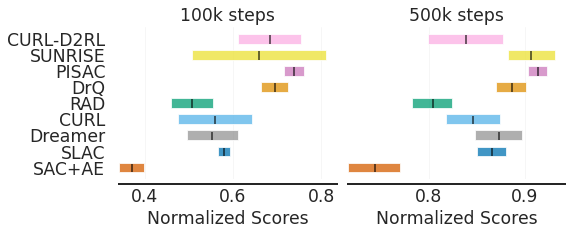

In [ ]:
#@title Plot Mean Scores

steps = ['100k', '500k']
fig, axes = plt.subplots(nrows=1, ncols=len(steps), figsize=(8, 2.8))
h = 0.6
algs = ['SAC+AE', 'SLAC', 'Dreamer', 'CURL', 'RAD', 'DrQ', 
        'PISAC', 'SUNRISE', 'CURL-D2RL']
for idx, step in enumerate(steps):
  perf_res = all_mean_CIs[step]
  score_dmc_step = score_dmc_all[step]
  ax = axes[idx]
  for i, alg in enumerate(algs):  
    (l, u), p = perf_res[alg], score_dmc_step[alg]
    ax.barh(y=i, width=u-l, height=h, 
            left=l, color=DMC_COLOR_DICT[alg], 
            alpha=0.75, label=alg,)
    ax.vlines(x=p, ymin=i-h/2, ymax=i+(6*h/16),
              label=alg, color='k', alpha=0.75)       
  ax.set_yticks(list(range(len(algs))))
  if idx != 0:
    ax.set_yticklabels([])
  else:
    ax.set_yticklabels(algs, fontsize='x-large')
  ax.set_title(steps[idx] + ' steps', fontsize='xx-large')
  ax.tick_params(axis='both', which='major', labelsize='x-large')
  ax.set_xlabel('Normalized Scores', fontsize='xx-large')
  decorate_axis(ax, wrect=5, labelsize='xx-large')
  ax.spines['left'].set_visible(False)
  ax.grid(alpha=0.2, axis='x')
plt.subplots_adjust(wspace=0.05)
plt.show()

INFO:absl:Calculating estimates for SLAC ...
INFO:absl:Calculating estimates for SAC+AE ...
INFO:absl:Calculating estimates for Dreamer ...
INFO:absl:Calculating estimates for PISAC ...
INFO:absl:Calculating estimates for RAD ...
INFO:absl:Calculating estimates for DrQ ...


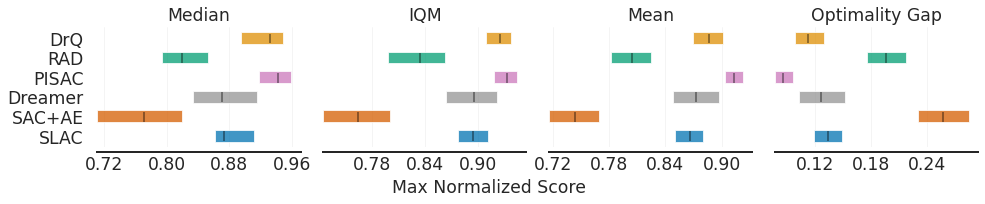

In [ ]:
#@title Aggregates on DMC (with 10 runs)

steps = '500k'
aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    normalized_dmc_scores[steps], aggregate_func, reps=50000)

algorithms =  ['SLAC', 'SAC+AE', 'Dreamer', 'PISAC', 'RAD', 'DrQ']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    colors=DMC_COLOR_DICT,
    xlabel_y_coordinate=-0.16,
    xlabel='Max Normalized Score')
plt.show()
# save_fig(fig, 'dmc_500k_aggregates')

### Atari 200M

In [1]:
#@title Download runs for ALE

#!gsutil -m cp -R gs://rl-benchmark-data/ALE ./

In [2]:
#@title Calculate Human AND Random scores

# These are taken from the MuZero paper
# Games Average-Human Random Agent57 R2D2 (Bandit) MuZero
my_str="""alien 7127.70 227.80 297638.17 ± 37054.55 464232.43 ± 7988.66 741812.63
amidar 1719.50 5.80 29660.08 ± 880.39 31331.37 ± 817.79 28634.39
assault 742.00 222.40 67212.67 ± 6150.59 110100.04 ± 346.06 143972.03
asterix 8503.30 210.00 991384.42 ± 9493.32 999354.03 ± 12.94 998425.00
asteroids 47388.70 719.10 150854.61 ± 16116.72 431072.45 ± 1799.13 6785558.64
atlantis 29028.10 12850.00 1528841.76 ± 28282.53 1660721.85 ± 14643.83 1674767.20
bank_heist 753.10 14.20 23071.50 ± 15834.73 27117.85 ± 963.12 1278.98
battle_zone 37187.50 2360.00 934134.88 ± 38916.03 992600.31 ± 1096.19 848623.00
beam_rider 16926.50 363.90 300509.80 ± 13075.35 390603.06 ± 23304.09 4549993.53
berzerk 2630.40 123.70 61507.83 ± 26539.54 77725.62 ± 4556.93 85932.60
bowling 160.70 23.10 251.18 ± 13.22 161.77 ± 99.84 260.13
boxing 12.10 0.10 100.00 ± 0.00 100.00 ± 0.00 100.00
breakout 30.50 1.70 790.40 ± 60.05 863.92 ± 0.08 864.00
centipede 12017.00 2090.90 412847.86 ± 26087.14 908137.24 ± 7330.99 1159049.27
chopper_command 7387.80 811.00 999900.00 ± 0.00 999900.00 ± 0.00 991039.70
crazy_climber 35829.40 10780.50 565909.85 ± 89183.85 729482.83 ± 87975.74 458315.40
defender 18688.90 2874.50 677642.78 ± 16858.59 730714.53 ± 715.54 839642.95
demon_attack 1971.00 152.10 143161.44 ± 220.32 143913.32 ± 92.93 143964.26
double_dunk -16.40 -18.60 23.93 ± 0.06 24.00 ± 0.00 23.94
enduro 860.50 0.00 2367.71 ± 8.69 2378.66 ± 3.66 2382.44
fishing_derby -38.70 -91.70 86.97 ± 3.25 90.34 ± 2.66 91.16
freeway 29.60 0.00 32.59 ± 0.71 34.00 ± 0.00 33.03
frostbite 4334.70 65.20 541280.88 ± 17485.76 309077.30 ± 274879.03 631378.53
gopher 2412.50 257.60 117777.08 ± 3108.06 129736.13 ± 653.03 130345.58
gravitar 3351.40 173.00 19213.96 ± 348.25 21068.03 ± 497.25 6682.70
hero 30826.40 1027.00 114736.26 ± 49116.60 49339.62 ± 4617.76 49244.11
ice_hockey 0.90 -11.20 63.64 ± 6.48 86.59 ± 0.59 67.04
jamesbond 302.80 29.00 135784.96 ± 9132.28 158142.36 ± 904.45 41063.25
kangaroo 3035.00 52.00 24034.16 ± 12565.88 18284.99 ± 817.25 16763.60
krull 2665.50 1598.00 251997.31 ± 20274.39 245315.44 ± 48249.07 269358.27
kung_fu_master 22736.30 258.50 206845.82 ± 11112.10 267766.63 ± 2895.73 204824.00
montezuma_revenge 4753.30 0.00 9352.01 ± 2939.78 3000.00 ± 0.00 0.00
ms_pacman 6951.60 307.30 63994.44 ± 6652.16 62595.90 ± 1755.82 243401.10
name_this_game 8049.00 2292.30 54386.77 ± 6148.50 138030.67 ± 5279.91 157177.85
phoenix 7242.60 761.40 908264.15 ± 28978.92 990638.12 ± 6278.77 955137.84
pitfall 6463.70 -229.40 18756.01 ± 9783.91 0.00 ± 0.00 0.00
pong 14.60 -20.70 20.67 ± 0.47 21.00 ± 0.00 21.00
private_eye 69571.30 24.90 79716.46 ± 29515.48 40700.00 ± 0.00 15299.98
qbert 13455.00 163.90 580328.14 ± 151251.66 777071.30 ± 190653.94 72276.00
riverraid 17118.00 1338.50 63318.67 ± 5659.55 93569.66 ± 13308.08 323417.18
road_runner 7845.00 11.50 243025.80 ± 79555.98 593186.78 ± 88650.69 613411.80
robotank 11.90 2.20 127.32 ± 12.50 144.00 ± 0.00 131.13
seaquest 42054.70 68.40 999997.63 ± 1.42 999999.00 ± 0.00 999976.52
skiing -4336.90 -17098.10 -4202.60 ± 607.85 -3851.44 ± 517.52 -29968.36
solaris 12326.70 1236.30 44199.93 ± 8055.50 67306.29 ± 10378.22 56.62
space_invaders 1668.70 148.00 48680.86 ± 5894.01 67898.71 ± 1744.74 74335.30
star_gunner 10250.00 664.00 839573.53 ± 67132.17 998600.28 ± 218.66 549271.70
surround 6.50 -10.00 9.50 ± 0.19 10.00 ± 0.00 9.99
tennis -8.30 -23.80 23.84 ± 0.10 24.00 ± 0.00 0.00
time_pilot 5229.20 3568.00 405425.31 ± 17044.45 460596.49 ± 3139.33 476763.90
tutankham 167.60 11.40 2354.91 ± 3421.43 483.78 ± 37.90 491.48
up_n_down 11693.20 533.40 623805.73 ± 23493.75 702700.36 ± 8937.59 715545.61
venture 1187.50 0.00 2623.71 ± 442.13 2258.93 ± 29.90 0.40
video_pinball 17667.90 0.00 992340.74 ± 12867.87 999645.92 ± 57.93 981791.88
wizard_of_wor 4756.50 563.50 157306.41 ± 16000.00 183090.81 ± 6070.10 197126.00
yars_revenge 54576.90 3092.90 998532.37 ± 375.82 999807.02 ± 54.85 553311.46
zaxxon 9173.30 32.50 249808.90 ± 58261.59 370649.03 ± 19761.32 725853.90"""


scores = my_str.split('\n')
ALL_HUMAN_SCORES = {}
ALL_RANDOM_SCORES = {}
for sc in scores:
  arr = sc.split(' ')
  game = inflection.camelize(arr[0]) 
  ALL_RANDOM_SCORES[game] = float(arr[2])
  ALL_HUMAN_SCORES[game] = float(arr[1])  

_ = ALL_HUMAN_SCORES.pop('Surround')
_ = ALL_HUMAN_SCORES.pop('Defender')

NameError: name 'inflection' is not defined

In [3]:
#@title Record scores on Atari games

ALL_HUMAN_RECORD = {
  'Alien': 251916.0,
  'Amidar': 104159.0,
  'Assault': 8647.0,
  'Asterix': 1000000.0,
  'Asteroids': 10506650.0,
  'Atlantis': 10604840.0,
  'BankHeist': 82058.0,
  'BattleZone': 801000.0,
  'BeamRider': 999999.0,
  'Berzerk': 1057940.0,
  'Bowling': 300.0,
  'Boxing': 100.0,
  'Breakout': 864.0,
  'Centipede': 1301709.0,
  'ChopperCommand': 999999.0,
  'CrazyClimber': 219900.0,
  'DemonAttack': 1556345.0,
  'DoubleDunk': 22.0,
  'Enduro': 9500.0,
  'FishingDerby': 71.0,
  'Freeway': 38.0,
  'Frostbite': 454830.0,
  'Gopher': 355040.0,
  'Gravitar': 162850.0,
  'Hero': 1000000.0,
  'IceHockey': 36.0,
  'Jamesbond': 45550.0,
  'Kangaroo': 1424600.0,
  'Krull': 104100.0,
  'KungFuMaster': 1000000.0,
  'MontezumaRevenge': 1219200.0,
  'MsPacman': 290090.0,
  'NameThisGame': 25220.0,
  'Phoenix': 4014440.0,
  'Pitfall': 114000.0,
  'Pong': 21.0,
  'PrivateEye': 101800.0,
  'Qbert': 2400000.0,
  'Riverraid': 1000000.0,
  'RoadRunner': 2038100.0,
  'Robotank': 76.0,
  'Seaquest': 999999.0,
  'Skiing': -3272.0,
  'Solaris': 111420.0,
  'SpaceInvaders': 621535.0,
  'StarGunner': 77400.0,
  'Tennis': 21.0,
  'TimePilot': 65300.0,
  'Tutankham': 5384.0,
  'UpNDown': 82840.0,
  'Venture': 38900.0,
  'VideoPinball': 89218328.0,
  'WizardOfWor': 395300.0,
  'YarsRevenge': 15000105.0,
  'Zaxxon': 83700.0,
  'AirRaid': 23050.0,
  'Carnival': 2541440.0,
  'ElevatorAction': 156550.0,
  'JourneyEscape': -4317804.0,
  'Pooyan': 13025.0
}

In [ ]:
#@title Atari 200m Helpers

def score_normalization_all_atari(res_dict, record_scores=False):
  games = res_dict.keys()
  norm_baseline = ALL_HUMAN_RECORD if record_scores else ALL_HUMAN_SCORES 
  norm_scores = {}
  for game, scores in res_dict.items():
    if (game in ALL_HUMAN_SCORES):
      norm_scores[game] = (scores - ALL_RANDOM_SCORES[game])/(norm_baseline[game] - ALL_RANDOM_SCORES[game])
  return norm_scores

def normalized_scores(res_dict, record_scores=False):
  scores = score_normalization_all_atari(
      res_dict, record_scores=record_scores)
  return convert_to_matrix(scores)

def convert_to_matrix(x):
  return np.stack([x[k] for k in sorted(x.keys())], axis=-1)

In [ ]:
#@title Load Atari 200M scores

# Scores at final iteration
with open('ALE/atari_200m_scores.npy', 'rb') as f:
  atari_200m_scores = np.load(f, allow_pickle=True)
  atari_200m_scores = atari_200m_scores.tolist()

atari_200m_scores_norm_mat = {key: normalized_scores(val, record_scores=False)
                              for key, val in atari_200m_scores.items()}
atari_200m_scores_norm_record_mat = {key: normalized_scores(val, record_scores=True)
                                     for key, val in atari_200m_scores.items()}

# Scores at all 200 iterations

with open('ALE/atari_200_iters_scores.npy', 'rb') as f:
  atari_200m_iter_scores = np.load(f, allow_pickle=True)
  atari_200m_iter_scores = atari_200m_iter_scores.tolist()

atari_200m_iter_scores_norm = {key: normalized_scores(val, record_scores=False)
                              for key, val in atari_200m_iter_scores.items()}                                  
for key, val in atari_200m_iter_scores_norm.items():
  atari_200m_iter_scores_norm[key] = np.transpose(val, axes=(1, 2, 0))

In [ ]:
#@title Calculate score distributions for Atari 200M
atari_200m_tau = np.linspace(0.0, 8.0, 81)
perf_prof_atari_200m, perf_prof_atari_200m_cis = rly.create_performance_profile(
    atari_200m_scores_norm_mat, atari_200m_tau, reps=2000)

INFO:absl:Calculating estimates for C51 ...
INFO:absl:Calculating estimates for DQN (Adam) ...
INFO:absl:Calculating estimates for DQN (Nature) ...
INFO:absl:Calculating estimates for Rainbow ...
INFO:absl:Calculating estimates for IQN ...
INFO:absl:Calculating estimates for REM ...
INFO:absl:Calculating estimates for M-IQN ...
INFO:absl:Calculating estimates for DreamerV2 ...


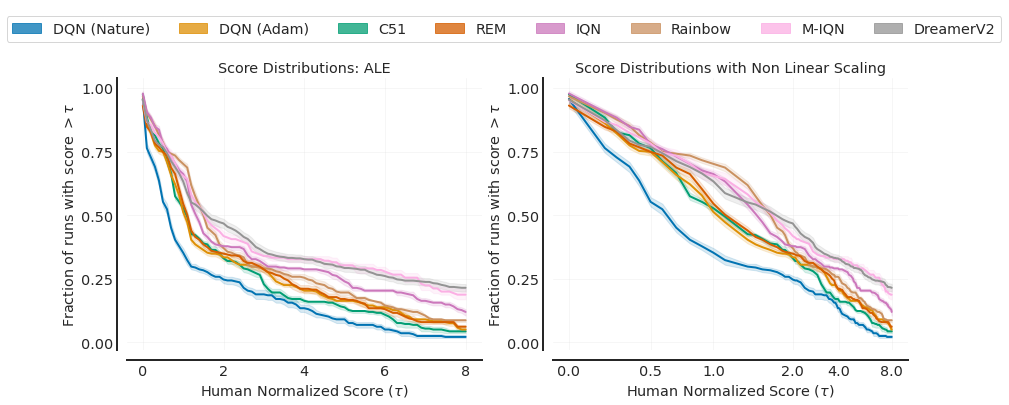

In [ ]:
#@title Score Distributions for Atari 200M

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']
fig, ax = plt.subplots(ncols=2, figsize=(7*2, 5))
color_dict = dict(zip(algorithms, sns.color_palette('colorblind')))

plot_utils.plot_performance_profiles(
  perf_prof_atari_200m, atari_200m_tau,
  performance_profile_cis=perf_prof_atari_200m_cis, 
  xticks=None, 
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax[0])
ax[0].set_title('Score Distributions: ALE', size='x-large')

xticks = [0.0, 0.5, 1.0, 2.0, 4.0, 8.0]
plot_utils.plot_performance_profiles(
  perf_prof_atari_200m, atari_200m_tau,
  performance_profile_cis=perf_prof_atari_200m_cis, 
  xticks=xticks,
  colors=color_dict,
  xlabel=r'Human Normalized Score $(\tau)$',
  use_non_linear_scaling=True,
  ax=ax[1])
ax[1].set_title('Score Distributions with Non Linear Scaling', size='x-large')

fake_patches = [mpatches.Patch(color=color_dict[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=len(algorithms), 
                    fontsize='x-large',
                    bbox_to_anchor=(0.5, 1.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.


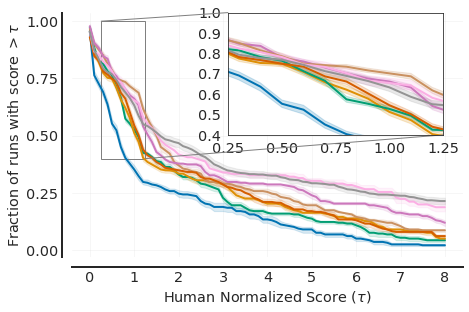

In [ ]:
#@title Performance profile for Atari200M

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

colors = sns.color_palette('colorblind')

num_seeds = 5
fig, ax = plt.subplots(figsize=(7, 4.5))

algs = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'IQN', 'Rainbow',  'M-IQN', 'DreamerV2']

# Experimental inset stuff
ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.4, 0.5, 0.55, 0.5])  # Second parameter is [xpos, ypos, width, height]
ax2.set_axes_locator(ip)
mark_inset(ax, ax2, loc1=2, loc2=4, fc='none', ec='0.5')

plot_utils.plot_performance_profiles(
  perf_prof_atari_200m, atari_200m_tau,
  performance_profile_cis=perf_prof_atari_200m_cis, 
  xticks=None, 
  colors=dict(zip(algs, sns.color_palette('colorblind'))),
  xlabel=r'Human Normalized Score $(\tau)$',
  ax=ax)
# ax[0].set_title('Score Distributions: ALE', size='x-large')

for idx, key in enumerate(algs):
  ci = perf_prof_atari_200m_cis[key]
  # Inset
  ax2.plot(atari_200m_tau, perf_prof_atari_200m[key], color=colors[idx], linewidth=2, label=key)
  ax2.fill_between(atari_200m_tau, ci[0], ci[1], color=colors[idx], alpha=0.2)

# Set x/y limits for inset
ax2.set_xlim((0.25, 1.25))
ax2.set_ylim((0.4, 1.0))
# Change tick sizes in inset
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize('x-large') 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize('x-large') 
ax2.set_xticks([0.25, 0.5, 0.75, 1.0, 1.25])
plt.show()

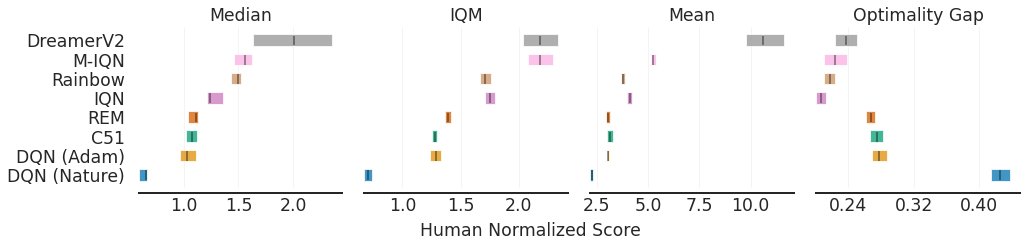

In [ ]:
#@title Uncertainty with bootstrap over runs only


# algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM',  
#         'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']

# aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
# aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
#     atari_200m_scores_norm_mat, aggregate_func, reps=50000)

fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.1,
    xlabel='Human Normalized Score')

plt.show()

C51 starting.
DQN (Adam) starting.
DQN (Nature) starting.
Rainbow starting.
IQN starting.
REM starting.
M-IQN starting.
DreamerV2 starting.


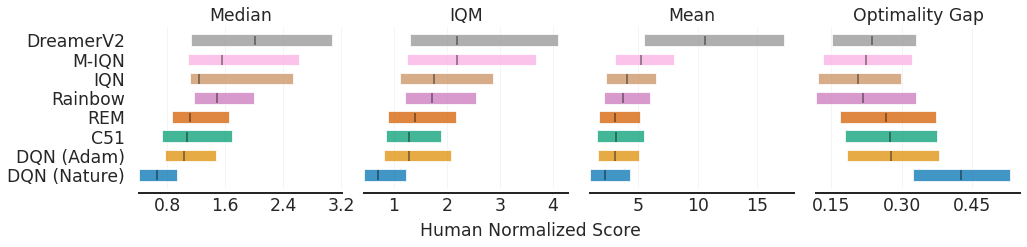

In [ ]:
#@title [Extra] Uncertainty with bootstrap over tasks and runs

aggregate_func = lambda x: np.array([MEDIAN(x), IQM(x), MEAN(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    atari_200m_scores_norm_mat, aggregate_func, reps=50000, task_bootstrap=True)

fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap'],
    algorithms=algorithms,
    xlabel_y_coordinate=-0.05,
    xlabel='Human Normalized Score')

plt.show()

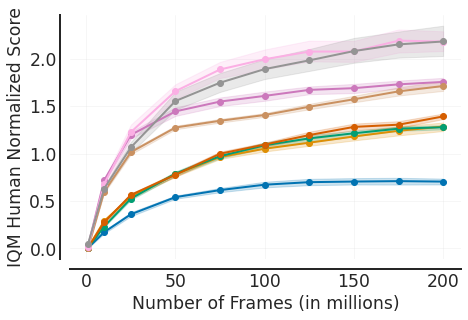

In [ ]:
#@title Plot Sample Efficiency Curve

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 
              'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
ale_all_frames_scores_dict = atari_200m_iter_scores_norm
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in ale_all_frames_scores_dict.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
# iqm_scores, iqm_cis = rly.get_interval_estimates(
#   ale_frames_scores_dict, iqm, reps=2000)

fig, ax = plt.subplots(figsize=(7, 4.5))
plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, 
    algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='IQM Human Normalized Score',
    ax=ax)

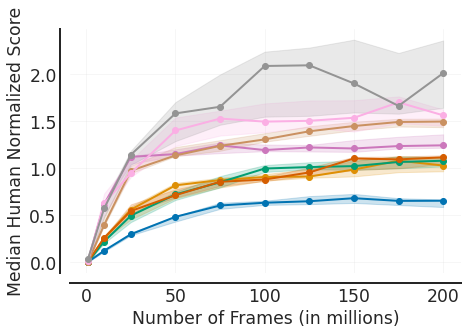

In [ ]:
#@title Median Sample Efficiency

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 
              'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices across all 200 million frames, each of which is of size
# `(num_runs x num_games x 200)` where scores are recorded every million frame.
ale_all_frames_scores_dict = atari_200m_iter_scores_norm
frames = np.array([1, 10, 25, 50, 75, 100, 125, 150, 175, 200]) - 1
ale_frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in ale_all_frames_scores_dict.items()}
median = lambda scores: np.array([metrics.aggregate_median(scores[..., frame])
                               for frame in range(scores.shape[-1])])
median_scores, median_cis = rly.get_interval_estimates(
  ale_frames_scores_dict, median, reps=2000)

color_dict = dict(zip(algorithms, sns.color_palette('colorblind')))
fig, ax = plt.subplots(figsize=(7, 4.5))
plot_utils.plot_sample_efficiency_curve(
    frames+1, median_scores, median_cis, 
    algorithms=algorithms,
    xlabel=r'Number of Frames (in millions)',
    ylabel='Median Human Normalized Score',
    ax=ax)
fake_patches = [mpatches.Patch(color=color_dict[alg], 
                               alpha=0.75) for alg in algorithms]
legend = fig.legend(fake_patches, algorithms, loc='upper center', 
                    fancybox=True, ncol=len(algorithms)//2, 
                    fontsize='x-large',
                    bbox_to_anchor=(0.5, 1.2))
plt.show()

INFO:absl:Calculating estimates for C51 ...
INFO:absl:Calculating estimates for DQN (Adam) ...
INFO:absl:Calculating estimates for DQN (Nature) ...
INFO:absl:Calculating estimates for Rainbow ...
INFO:absl:Calculating estimates for IQN ...
INFO:absl:Calculating estimates for REM ...
INFO:absl:Calculating estimates for M-IQN ...
INFO:absl:Calculating estimates for DreamerV2 ...


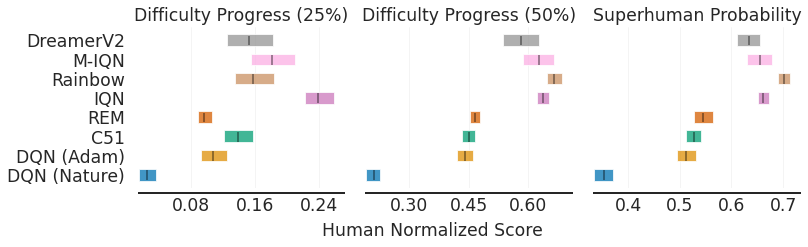

In [ ]:
#@title Alternative Aggregate metrics -- Difficulty Progress/ SuperHuman Probability


def difficulty_progress(scores, proportion=0.25):
  sorted_scores = sorted(scores.flatten())
  max_index = int(proportion * len(sorted_scores))
  return np.mean(sorted_scores[:max_index])


DP_25 = lambda scores: difficulty_progress(scores, 0.25)
DP_50 = lambda scores: difficulty_progress(scores, 0.5)
improvement_prob = lambda scores: np.mean(scores > 1)

aggregate_func = lambda x: np.array([DP_25(x), DP_50(x), improvement_prob(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    atari_200m_scores_norm_mat, aggregate_func, reps=50000)

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 
        'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']
metric_names=['Difficulty Progress (25%)', 'Difficulty Progress (50%)',
              'Superhuman Probability']
fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates, 
    algorithms=algorithms,
    metric_names=metric_names,
    xlabel='Human Normalized Score')
plt.show()

In [ ]:
#@title Performance profile for Atari200M

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

colors = sns.color_palette('colorblind')

num_seeds = 5
fig, ax = plt.subplots(figsize=(7, 4.3))

algs = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'Rainbow', 'IQN', 'M-IQN', 'DreamerV2']

# Experimental inset stuff
ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax, [0.4, 0.5, 0.55, 0.5])  # Second parameter is [xpos, ypos, width, height]
ax2.set_axes_locator(ip)
mark_inset(ax, ax2, loc1=2, loc2=4, fc='none', ec='0.5')

for idx, key in enumerate(algs):
  score_data = atari_200m_scores_norm_mat[key]
  ci = perf_prof_atari_ci[key]
  label = 'DQN (Adam)' if key == 'DQN' else key
  perf_prof = pf_fun(score_data)
  ax.plot(ATARI_TAU, perf_prof, color=colors[idx], linewidth=2, label=label)
  ax.fill_between(ATARI_TAU, ci[0], ci[1], color=colors[idx], alpha=0.2)
  # Inset
  ax2.plot(ATARI_TAU, perf_prof, color=colors[idx], linewidth=2, label=label)
  ax2.fill_between(ATARI_TAU, ci[0], ci[1], color=colors[idx], alpha=0.2)

# Set x/y limits for inset
ax2.set_xlim((0.25, 1.25))
ax2.set_ylim((0.4, 1.0))
# Change tick sizes in inset
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize('x-large') 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize('x-large') 
ax2.set_xticks([0.25, 0.5, 0.75, 1.0, 1.25])

label_fontsize='xx-large'
tick_fontsize='xx-large'
ax.set_xlabel('Human Normalized Score ' + r'$(\tau)$', 
              fontsize=label_fontsize)
ylabel = r'Fraction of runs with score $\geq \tau$'
ax.set_ylabel(ylabel, fontsize='x-large')
# ax.set_title(f'Performance profile on Atari 200M', fontsize=label_fontsize)
ax.set_xscale('linear')
ax.grid(True, alpha=0.2)
# plt.legend(fontsize='large', bbox_to_anchor=(1.2, 1.5), loc='upper left')
decorate_axis(ax, wrect=10, hrect=10, labelsize='x-large')

# fake_patches = [mpatches.Patch(color=colors[m], alpha=0.75) for m in range(len(algs))]
# legend = fig.legend(fake_patches, algs, loc='upper center', 
#                     fancybox=True, ncol=4, fontsize=16,
#                     columnspacing=0.5)
# fig.subplots_adjust(top=0.77, wspace=0.0)
plt.show()

In [ ]:
#@title Compute Probability of Improvement P (X > Y) for a specified algorithm X

all_keys = atari_200m_scores_norm_mat.keys()

algorithms = ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 
        'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']

algorithm_X = 'DreamerV2' #@param ['DQN (Nature)', 'DQN (Adam)', 'C51', 'REM', 'IQN', 'Rainbow', 'M-IQN', 'DreamerV2']
alg = algorithm_X
all_pairs = {}
for alg2 in (algorithms):
  if alg2 == alg:
    continue
  pair_name = f'{alg}_{alg2}'
  all_pairs[pair_name] = (atari_200m_scores_norm_mat[alg], atari_200m_scores_norm_mat[alg2]) 

# Use a larger value reps for more accurate CIs but slower computation 
probabilities, probability_cis = rly.get_interval_estimates(
    all_pairs, metrics.probability_of_improvement, reps=1000)

INFO:absl:Calculating estimates for DreamerV2_DQN (Nature) ...
INFO:absl:Calculating estimates for DreamerV2_DQN (Adam) ...
INFO:absl:Calculating estimates for DreamerV2_C51 ...
INFO:absl:Calculating estimates for DreamerV2_REM ...
INFO:absl:Calculating estimates for DreamerV2_IQN ...
INFO:absl:Calculating estimates for DreamerV2_Rainbow ...
INFO:absl:Calculating estimates for DreamerV2_M-IQN ...


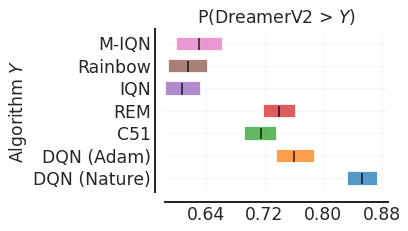

In [ ]:
#@title Plot probabilities of improvement P(X > Y) with 95% CIs

fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
  _, alg1 = alg_pair.split('_')
  algorithm_labels.append(alg1)
  (l, u) = probability_cis[alg_pair]
  ax.barh(y=i, width=u-l, height=h, 
          left=l, alpha=0.75)
  ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16),
            color='k', alpha=0.85)
ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)

ax.set_title(fr'P({alg} > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
plt.show()